# Day 3: GJR-GARCH and Threshold GARCH

## Learning Objectives
- Implement GJR-GARCH (Glosten-Jagannathan-Runkle)
- Understand threshold models
- Compare asymmetric GARCH variants
- Model selection for volatility

## Key Formula (GJR-GARCH)
$$\sigma_t^2 = \omega + (\alpha + \gamma I_{t-1}) \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

Where $I_{t-1} = 1$ if $\epsilon_{t-1} < 0$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy import stats
from pathlib import Path

DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252

df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna() * 100

print("="*60)
print("GJR-GARCH AND THRESHOLD MODELS - DAY 3")
print("="*60)

GJR-GARCH AND THRESHOLD MODELS - DAY 3


## 1. GJR-GARCH Model

In [2]:
stock = 'SPY'
stock_returns = returns[stock].dropna()

# Fit GJR-GARCH (GARCH with o=1 for asymmetry)
gjr_model = arch_model(stock_returns, vol='GARCH', p=1, o=1, q=1, mean='Constant')
gjr_result = gjr_model.fit(disp='off')

print("\n" + "="*60)
print("GJR-GARCH(1,1,1) MODEL RESULTS")
print("="*60)
print(gjr_result.summary())


GJR-GARCH(1,1,1) MODEL RESULTS
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2470.89
Distribution:                  Normal   AIC:                           4951.77
Method:            Maximum Likelihood   BIC:                           4979.34
                                        No. Observations:                 1834
Date:                Wed, Jan 21 2026   Df Residuals:                     1833
Time:                        00:46:06   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0620  1.8

In [3]:
# Extract and interpret parameters
omega_g = gjr_result.params['omega']
alpha_g = gjr_result.params['alpha[1]']
gamma_g = gjr_result.params['gamma[1]']  # Asymmetry term
beta_g = gjr_result.params['beta[1]']

print("\n" + "="*60)
print("GJR-GARCH PARAMETER INTERPRETATION")
print("="*60)
print(f"ω (omega): {omega_g:.6f}")
print(f"α (alpha): {alpha_g:.4f} - Effect of positive shock")
print(f"γ (gamma): {gamma_g:.4f} - ADDITIONAL effect of negative shock")
print(f"β (beta):  {beta_g:.4f} - Persistence")

print(f"\n📊 Impact Analysis:")
print(f"   Positive shock impact: α = {alpha_g:.4f}")
print(f"   Negative shock impact: α + γ = {alpha_g + gamma_g:.4f}")
print(f"   Asymmetry ratio: {(alpha_g + gamma_g)/alpha_g:.2f}x")

# Persistence calculation
persistence = alpha_g + 0.5*gamma_g + beta_g
print(f"\n   Persistence (α + γ/2 + β): {persistence:.4f}")


GJR-GARCH PARAMETER INTERPRETATION
ω (omega): 0.043517
α (alpha): 0.0375 - Effect of positive shock
γ (gamma): 0.2163 - ADDITIONAL effect of negative shock
β (beta):  0.8187 - Persistence

📊 Impact Analysis:
   Positive shock impact: α = 0.0375
   Negative shock impact: α + γ = 0.2538
   Asymmetry ratio: 6.77x

   Persistence (α + γ/2 + β): 0.9643


## 2. Compare All Asymmetric Models

In [4]:
# Fit all models
models = {}

# Standard GARCH
garch_model = arch_model(stock_returns, vol='GARCH', p=1, q=1)
models['GARCH(1,1)'] = garch_model.fit(disp='off')

# GJR-GARCH
gjr_model = arch_model(stock_returns, vol='GARCH', p=1, o=1, q=1)
models['GJR-GARCH'] = gjr_model.fit(disp='off')

# EGARCH
egarch_model = arch_model(stock_returns, vol='EGARCH', p=1, o=1, q=1)
models['EGARCH'] = egarch_model.fit(disp='off')

# TARCH (Threshold ARCH) - approximated with GARCH o=1
# Note: arch library uses GARCH with o parameter for threshold effects

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(f"{'Model':<15} {'Log-Lik':<12} {'AIC':<12} {'BIC':<12} {'Params':<8}")
print("-"*60)

results = []
for name, result in models.items():
    results.append({
        'Model': name,
        'LogLik': result.loglikelihood,
        'AIC': result.aic,
        'BIC': result.bic,
        'Params': len(result.params)
    })
    print(f"{name:<15} {result.loglikelihood:<12.2f} {result.aic:<12.2f} {result.bic:<12.2f} {len(result.params):<8}")

# Best model
results_df = pd.DataFrame(results)
best_aic = results_df.loc[results_df['AIC'].idxmin(), 'Model']
best_bic = results_df.loc[results_df['BIC'].idxmin(), 'Model']

print(f"\n✓ Best by AIC: {best_aic}")
print(f"✓ Best by BIC: {best_bic}")


MODEL COMPARISON
Model           Log-Lik      AIC          BIC          Params  
------------------------------------------------------------
GARCH(1,1)      -2498.99     5005.98      5028.03      4       
GJR-GARCH       -2470.89     4951.77      4979.34      5       
EGARCH          -2465.47     4940.95      4968.52      5       

✓ Best by AIC: EGARCH
✓ Best by BIC: EGARCH


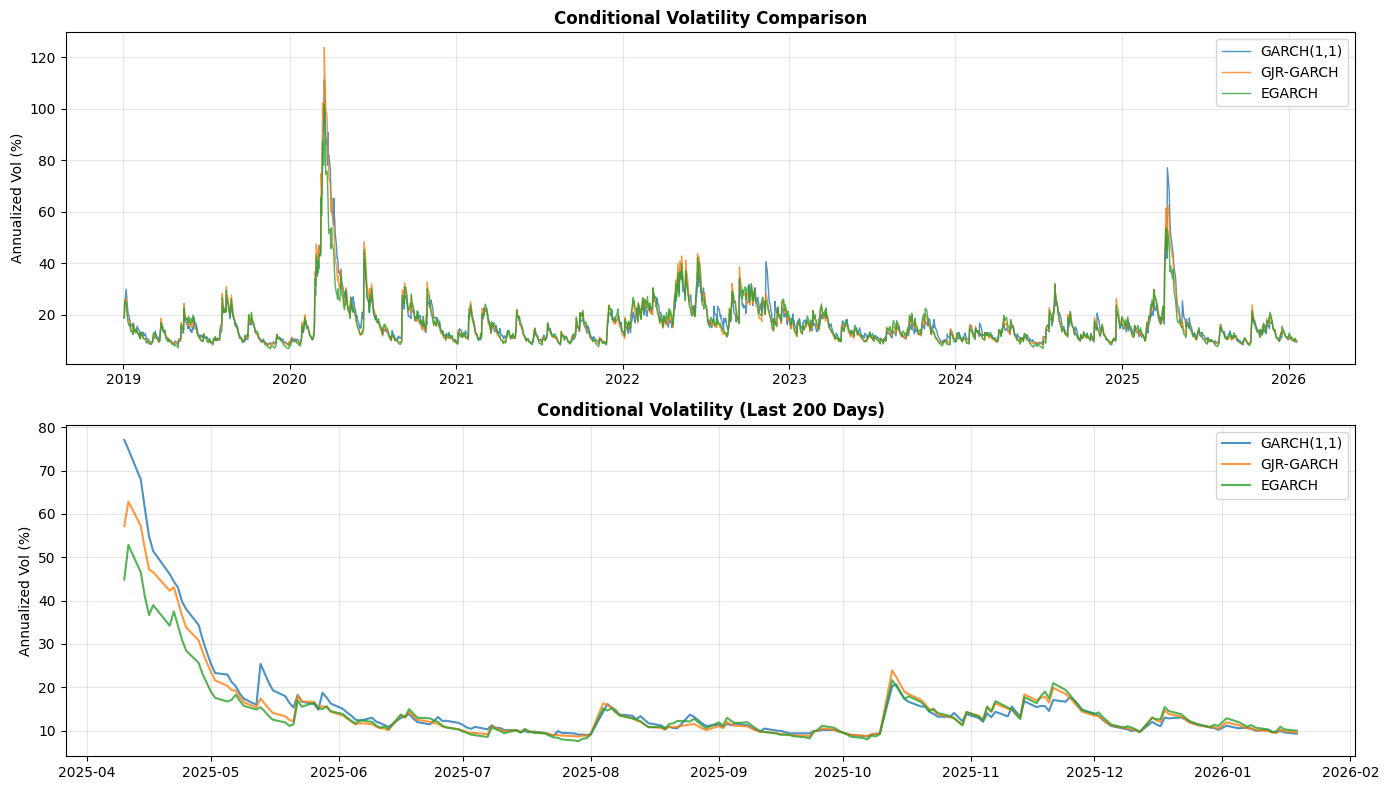

In [5]:
# Compare conditional volatilities
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

ax1 = axes[0]
for name, result in models.items():
    vol = result.conditional_volatility * np.sqrt(TRADING_DAYS)
    ax1.plot(vol, label=name, alpha=0.8, linewidth=1)
ax1.set_title('Conditional Volatility Comparison', fontweight='bold')
ax1.set_ylabel('Annualized Vol (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoom to recent period
ax2 = axes[1]
for name, result in models.items():
    vol = result.conditional_volatility * np.sqrt(TRADING_DAYS)
    ax2.plot(vol.iloc[-200:], label=name, alpha=0.8, linewidth=1.5)
ax2.set_title('Conditional Volatility (Last 200 Days)', fontweight='bold')
ax2.set_ylabel('Annualized Vol (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. News Impact Curve Comparison

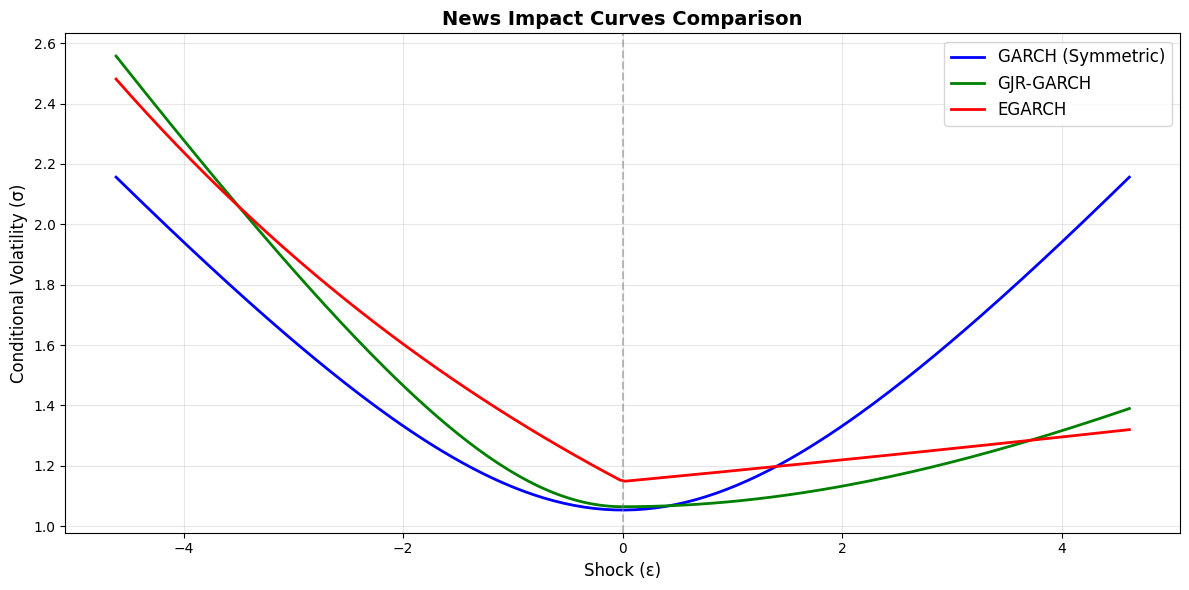


💡 Key Observations:
   - GARCH: Symmetric V-shape
   - GJR-GARCH: Kinked at zero (discontinuous derivative)
   - EGARCH: Smooth asymmetric curve


In [6]:
# News impact curves for all models
def garch_nic(eps, omega, alpha, beta, sigma_bar):
    return omega + alpha * eps**2 + beta * sigma_bar**2

def gjr_nic(eps, omega, alpha, gamma, beta, sigma_bar):
    indicator = (eps < 0).astype(float)
    return omega + (alpha + gamma * indicator) * eps**2 + beta * sigma_bar**2

def egarch_nic(eps, omega, alpha, gamma, beta, sigma_bar):
    z = eps / sigma_bar
    log_var = omega + alpha * np.abs(z) + gamma * z + beta * np.log(sigma_bar**2)
    return np.exp(log_var)

# Parameters
garch_params = models['GARCH(1,1)'].params
gjr_params = models['GJR-GARCH'].params
egarch_params = models['EGARCH'].params

sigma_bar = np.sqrt(garch_params['omega'] / (1 - garch_params['alpha[1]'] - garch_params['beta[1]']))
eps_range = np.linspace(-4*sigma_bar, 4*sigma_bar, 200)

# Calculate curves
garch_curve = np.sqrt(garch_nic(eps_range, garch_params['omega'], garch_params['alpha[1]'], 
                                 garch_params['beta[1]'], sigma_bar))
gjr_curve = np.sqrt(gjr_nic(eps_range, gjr_params['omega'], gjr_params['alpha[1]'], 
                             gjr_params['gamma[1]'], gjr_params['beta[1]'], sigma_bar))
egarch_curve = np.sqrt(egarch_nic(eps_range, egarch_params['omega'], egarch_params['alpha[1]'],
                                   egarch_params['gamma[1]'], egarch_params['beta[1]'], sigma_bar))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(eps_range, garch_curve, 'b-', linewidth=2, label='GARCH (Symmetric)')
ax.plot(eps_range, gjr_curve, 'g-', linewidth=2, label='GJR-GARCH')
ax.plot(eps_range, egarch_curve, 'r-', linewidth=2, label='EGARCH')

ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Shock (ε)', fontsize=12)
ax.set_ylabel('Conditional Volatility (σ)', fontsize=12)
ax.set_title('News Impact Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("   - GARCH: Symmetric V-shape")
print("   - GJR-GARCH: Kinked at zero (discontinuous derivative)")
print("   - EGARCH: Smooth asymmetric curve")

## 4. Model Diagnostics

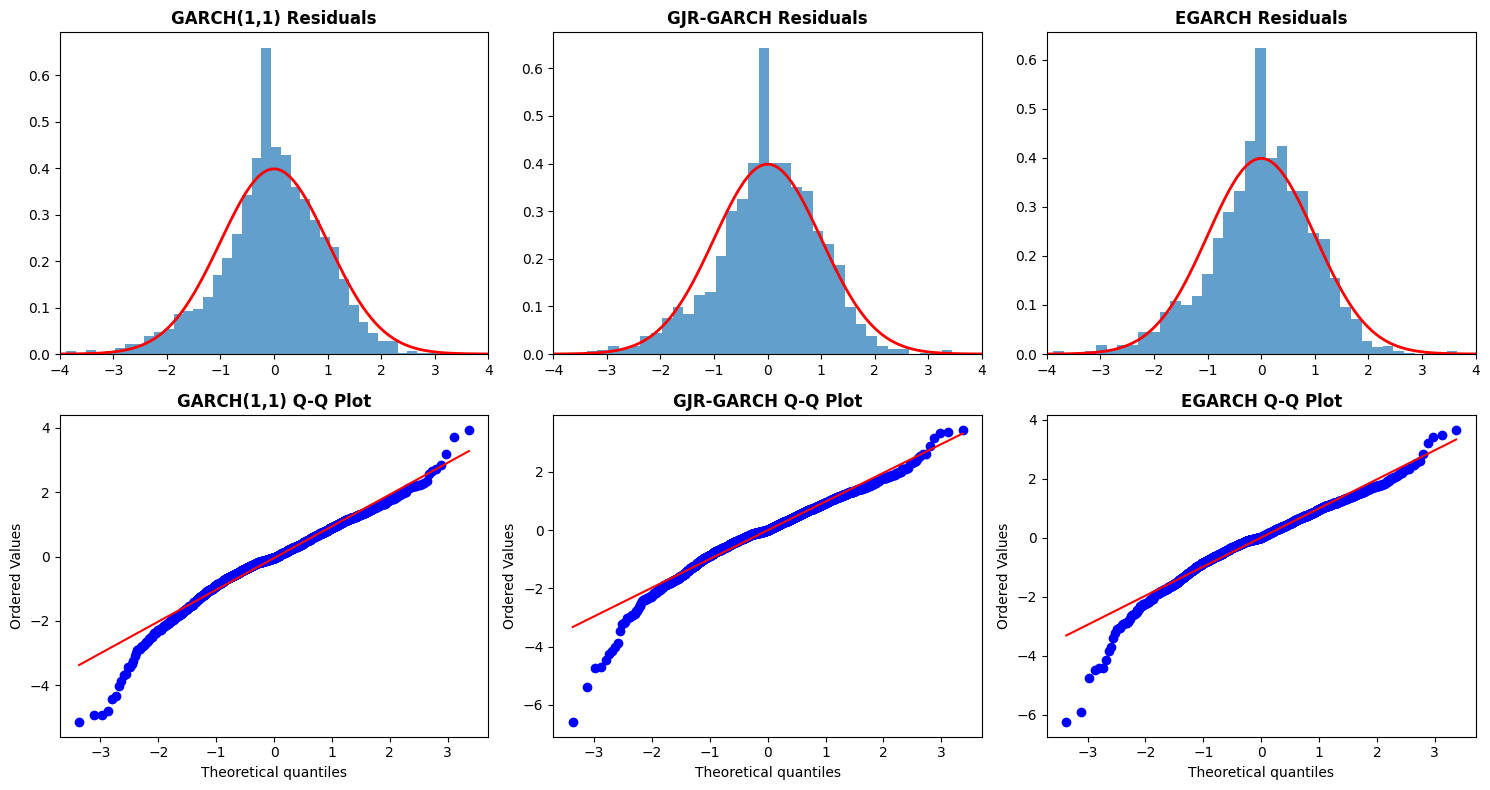

In [7]:
# Standardized residual diagnostics
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, (name, result) in enumerate(models.items()):
    # Histogram
    ax = axes[0, i]
    std_resid = result.std_resid.dropna()
    ax.hist(std_resid, bins=50, density=True, alpha=0.7)
    x = np.linspace(-4, 4, 100)
    ax.plot(x, stats.norm.pdf(x), 'r-', linewidth=2)
    ax.set_title(f'{name} Residuals', fontweight='bold')
    ax.set_xlim(-4, 4)
    
    # QQ plot
    ax = axes[1, i]
    stats.probplot(std_resid, dist='norm', plot=ax)
    ax.set_title(f'{name} Q-Q Plot', fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# Statistical tests
print("\n" + "="*70)
print("RESIDUAL DIAGNOSTICS")
print("="*70)
print(f"{'Model':<15} {'Skewness':<12} {'Kurtosis':<12} {'JB Stat':<12} {'JB p-val':<12}")
print("-"*60)

for name, result in models.items():
    std_resid = result.std_resid.dropna()
    skew = stats.skew(std_resid)
    kurt = stats.kurtosis(std_resid)
    jb_stat, jb_pval = stats.jarque_bera(std_resid)
    
    print(f"{name:<15} {skew:<12.4f} {kurt:<12.4f} {jb_stat:<12.2f} {jb_pval:<12.6f}")

print("\n💡 Normal distribution: Skewness=0, Kurtosis=0")


RESIDUAL DIAGNOSTICS
Model           Skewness     Kurtosis     JB Stat      JB p-val    
------------------------------------------------------------
GARCH(1,1)      -0.6288      2.0644       446.54       0.000000    
GJR-GARCH       -0.7428      2.6849       719.51       0.000000    
EGARCH          -0.7412      2.6749       714.70       0.000000    

💡 Normal distribution: Skewness=0, Kurtosis=0


## 5. Apply to Multiple Assets

In [9]:
# Compare asymmetry across assets
test_stocks = ['AAPL', 'MSFT', 'JPM', 'XOM', 'SPY', 'GLD']

print("\n" + "="*80)
print("GJR-GARCH ASYMMETRY ACROSS ASSETS")
print("="*80)
print(f"{'Stock':<8} {'α':<10} {'γ':<10} {'α+γ':<10} {'Ratio':<10} {'Significant':<12}")
print("-"*65)

asymmetry_results = []
for s in test_stocks:
    if s in returns.columns:
        model = arch_model(returns[s].dropna(), vol='GARCH', p=1, o=1, q=1)
        res = model.fit(disp='off')
        
        alpha = res.params['alpha[1]']
        gamma = res.params['gamma[1]']
        gamma_pval = res.pvalues['gamma[1]']
        
        ratio = (alpha + gamma) / alpha if alpha > 0 else np.nan
        sig = "Yes" if gamma_pval < 0.05 else "No"
        
        asymmetry_results.append({
            'stock': s,
            'alpha': alpha,
            'gamma': gamma,
            'ratio': ratio,
            'significant': sig
        })
        
        print(f"{s:<8} {alpha:<10.4f} {gamma:<10.4f} {alpha+gamma:<10.4f} {ratio:<10.2f} {sig:<12}")


GJR-GARCH ASYMMETRY ACROSS ASSETS
Stock    α          γ          α+γ        Ratio      Significant 
-----------------------------------------------------------------
AAPL     0.0285     0.1636     0.1921     6.74       Yes         
MSFT     0.0344     0.0945     0.1288     3.75       Yes         
JPM      0.0120     0.1365     0.1486     12.33      No          
XOM      0.0461     0.0329     0.0790     1.71       No          
SPY      0.0375     0.2163     0.2538     6.77       Yes         
GLD      0.1395     -0.0939    0.0456     0.33       Yes         


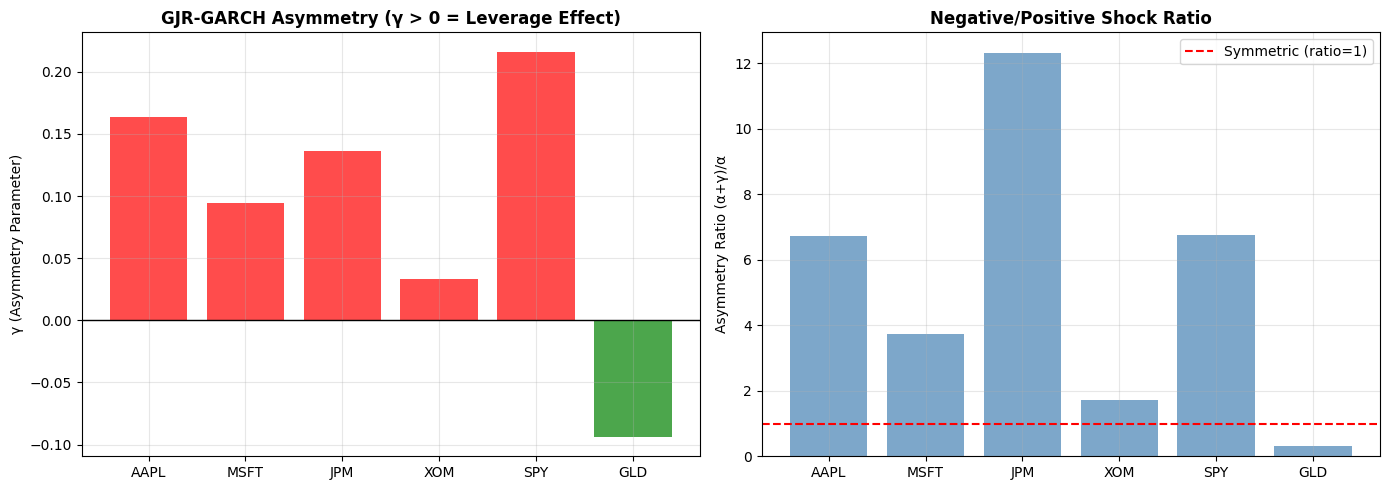

In [10]:
# Visualize asymmetry
asymmetry_df = pd.DataFrame(asymmetry_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gamma values
ax1 = axes[0]
colors = ['red' if g > 0 else 'green' for g in asymmetry_df['gamma']]
ax1.bar(asymmetry_df['stock'], asymmetry_df['gamma'], color=colors, alpha=0.7)
ax1.axhline(0, color='black', linewidth=1)
ax1.set_ylabel('γ (Asymmetry Parameter)')
ax1.set_title('GJR-GARCH Asymmetry (γ > 0 = Leverage Effect)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Ratio
ax2 = axes[1]
ax2.bar(asymmetry_df['stock'], asymmetry_df['ratio'], color='steelblue', alpha=0.7)
ax2.axhline(1, color='red', linestyle='--', label='Symmetric (ratio=1)')
ax2.set_ylabel('Asymmetry Ratio (α+γ)/α')
ax2.set_title('Negative/Positive Shock Ratio', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

1. **GJR-GARCH** uses indicator function for asymmetry
2. **γ > 0** in GJR confirms leverage effect
3. **Different formulations** give similar insights
4. **Model selection** via AIC/BIC helps choose best model
5. **Equities typically show** strong leverage effect, commodities less so

### Model Comparison
| Model | Asymmetry | Positivity | Interpretation |
|-------|-----------|------------|----------------|
| GARCH | No | Constraint | Simple baseline |
| GJR-GARCH | Yes | Constraint | Easy to interpret |
| EGARCH | Yes | No constraint | Smooth response |

---
*Next: Day 4 - Multivariate GARCH (DCC)*